# Workflow Templates & Graph Bootstrap

Load workflow patterns from YAML files to bootstrap the GraphRAG tool dependency graph.

**Features:**

- Two YAML formats: `steps` (linear) or `edges` (DAG)
- Validation with warnings for unknown tools
- Checksum-based change detection
- Graph visualization

## Setup

In [1]:
import { WorkflowLoader } from "../../src/graphrag/workflow-loader.ts";
import {
  displayMermaid,
  displayWorkflowEdges,
  workflowEdgesToMermaid,
  workflowStats,
} from "../lib/viz.ts";

const loader = new WorkflowLoader();
console.log("✅ WorkflowLoader ready");

✅ WorkflowLoader ready


## Format 1: Linear Workflows (steps)

Simple sequential tool chains:

```yaml
- name: my_workflow
  steps: [A, B, C] # Creates edges: A→B, B→C
```

In [2]:
// Define linear workflows programmatically
const linearWorkflows = [
  {
    name: "fetch_parse_save",
    steps: ["api:fetch", "json:parse", "db:save"],
  },
  {
    name: "search_summarize",
    steps: ["web:search", "browser:fetch", "llm:summarize"],
  },
];

// Validate
const linearResults = loader.validate(linearWorkflows);
console.log(
  "Validation:",
  linearResults.map((r) => `${r.workflow.name}: ${r.valid ? "✅" : "❌"}`).join(", "),
);

// Convert to edges
const linearEdges = loader.convertToEdges(linearWorkflows);
console.log(`\n${workflowStats(linearWorkflows)}`);
console.log("\nEdges:");
linearEdges.forEach((e) => console.log(`  ${e.from} → ${e.to} (${e.workflowName})`));

Validation: fetch_parse_save: ✅, search_summarize: ✅

Workflow Stats:
  - Total workflows: 2
  - Using steps (linear): 2
  - Using edges (DAG): 0
  - Total edges: 4

Edges:
  api:fetch → json:parse (fetch_parse_save)
  json:parse → db:save (fetch_parse_save)
  web:search → browser:fetch (search_summarize)
  browser:fetch → llm:summarize (search_summarize)


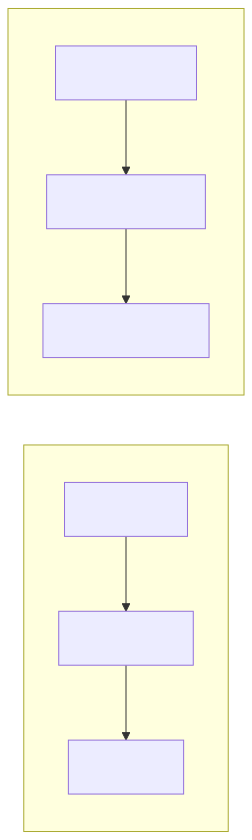

In [3]:
// Visualize linear workflows
await displayWorkflowEdges(linearEdges);

## Format 2: DAG Workflows (edges)

Complex workflows with parallel branches:

```yaml
- name: my_dag
  edges:
    - [A, B]
    - [A, C] # A leads to BOTH B and C (parallel)
    - [B, D]
    - [C, D] # D waits for both B and C
```

In [4]:
// Define DAG workflows with explicit edges
const dagWorkflows = [
  {
    name: "parallel_processing",
    edges: [
      ["fetch:data", "transform:parse"],
      ["fetch:data", "validate:schema"], // Fan-out: fetch leads to 2 tasks
      ["transform:parse", "db:save"],
      ["validate:schema", "db:save"], // Fan-in: save waits for both
    ] as [string, string][],
  },
  {
    name: "multi_analysis",
    edges: [
      ["web:fetch", "llm:summarize"],
      ["web:fetch", "llm:extract_entities"],
      ["web:fetch", "llm:sentiment"],
      ["llm:summarize", "report:generate"],
      ["llm:extract_entities", "report:generate"],
      ["llm:sentiment", "report:generate"],
    ] as [string, string][],
  },
];

// Validate
const dagResults = loader.validate(dagWorkflows);
console.log(
  "Validation:",
  dagResults.map((r) => `${r.workflow.name}: ${r.valid ? "✅" : "❌"}`).join(", "),
);

// Convert to edges
const dagEdges = loader.convertToEdges(dagWorkflows);
console.log(`\n${workflowStats(dagWorkflows)}`);

Validation: parallel_processing: ✅, multi_analysis: ✅

Workflow Stats:
  - Total workflows: 2
  - Using steps (linear): 0
  - Using edges (DAG): 2
  - Total edges: 10


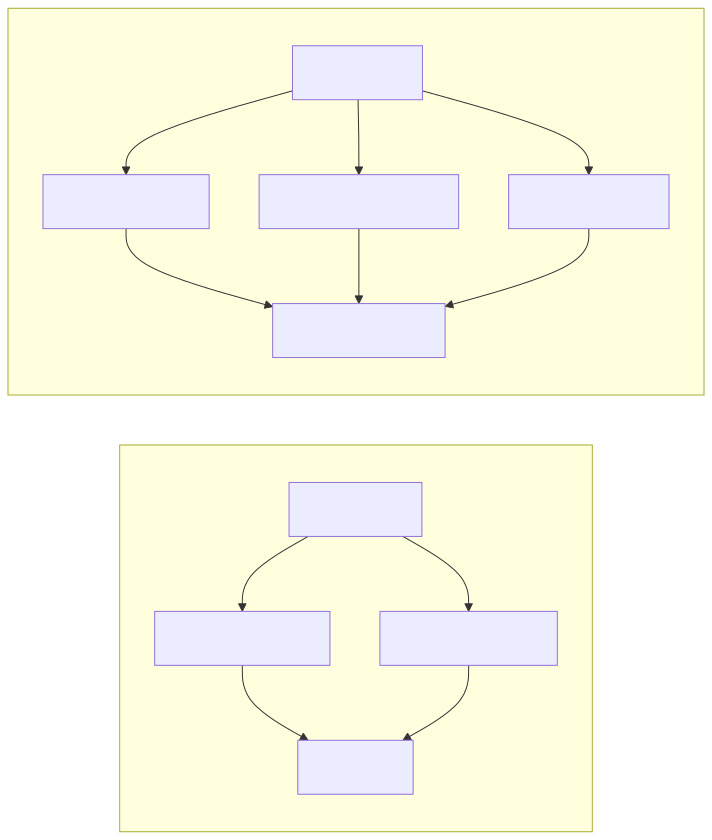

In [5]:
// Visualize DAG workflows (grouped by workflow name)
await displayWorkflowEdges(dagEdges);

## Mixed Workflows

Combine linear and DAG workflows in the same file:

Workflow Stats:
  - Total workflows: 2
  - Using steps (linear): 1
  - Using edges (DAG): 1
  - Total edges: 6


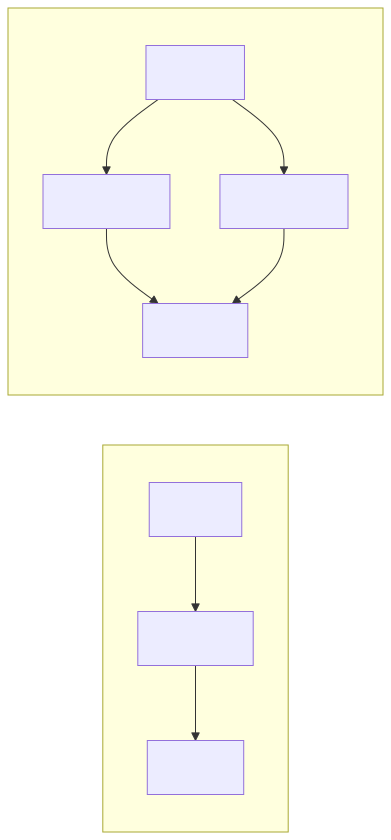

In [6]:
const mixedWorkflows = [
  // Linear workflow
  { name: "simple_pipeline", steps: ["read", "process", "write"] },
  // DAG workflow
  {
    name: "complex_pipeline",
    edges: [
      ["input", "branch_a"],
      ["input", "branch_b"],
      ["branch_a", "merge"],
      ["branch_b", "merge"],
    ] as [string, string][],
  },
];

const mixedEdges = loader.convertToEdges(mixedWorkflows);
console.log(workflowStats(mixedWorkflows));

// Visualize
await displayWorkflowEdges(mixedEdges);

## Load from YAML File

Load workflows from `config/workflow-templates.yaml`:

In [7]:
// Load and process from YAML file
const yamlPath = "../../config/workflow-templates.yaml";

try {
  const result = await loader.loadAndProcess(yamlPath);

  console.log(`📁 Loaded from: ${yamlPath}`);
  console.log(`   Workflows: ${result.workflows.length}`);
  console.log(`   Valid: ${result.validWorkflows.length}`);
  console.log(`   Edges: ${result.edges.length}`);

  if (result.edges.length > 0) {
    console.log("\n📊 Visualizing loaded workflows...");
    await displayWorkflowEdges(result.edges);
  } else {
    console.log("\n⚠️  No workflows defined in YAML file (this is expected for empty config)");
  }
} catch (error) {
  console.error("❌ Error loading YAML:", error.message);
}

INFO [WorkflowLoader] Loading templates from: ../../config/workflow-templates.yaml
INFO [WorkflowLoader] Loaded 0 workflow templates
INFO [WorkflowLoader] Processed 0 workflows: 0 valid, 0 invalid, 0 warnings
📁 Loaded from: ../../config/workflow-templates.yaml
   Workflows: 0
   Valid: 0
   Edges: 0

⚠️  No workflows defined in YAML file (this is expected for empty config)


## Validation & Unknown Tool Warnings

The loader can warn about unknown tools without failing:

In [8]:
// Set known tools for validation
loader.setKnownTools(["api:fetch", "json:parse", "db:save"]);

const workflowsWithUnknown = [
  {
    name: "mixed_tools",
    steps: ["api:fetch", "unknown:tool", "db:save"],
  },
];

const validationResults = loader.validate(workflowsWithUnknown);

console.log("Validation result:");
console.log(`  Valid: ${validationResults[0].valid}`);
console.log(`  Errors: ${validationResults[0].errors.length}`);
console.log(`  Warnings: ${validationResults[0].warnings.length}`);
if (validationResults[0].warnings.length > 0) {
  console.log("\n⚠️  Warnings:");
  validationResults[0].warnings.forEach((w) => console.log(`    - ${w}`));
}

WARN [WorkflowLoader] Unknown tool ID 'unknown:tool' in workflow 'mixed_tools'
Validation result:
  Valid: true
  Errors: 0
  Warnings: 1

⚠️  Warnings:
    - Unknown tool ID 'unknown:tool' in workflow 'mixed_tools'


## Flat Graph View (Merged Workflows)

View all edges as a single graph (shared nodes across workflows):

Total edges from all workflows: 14


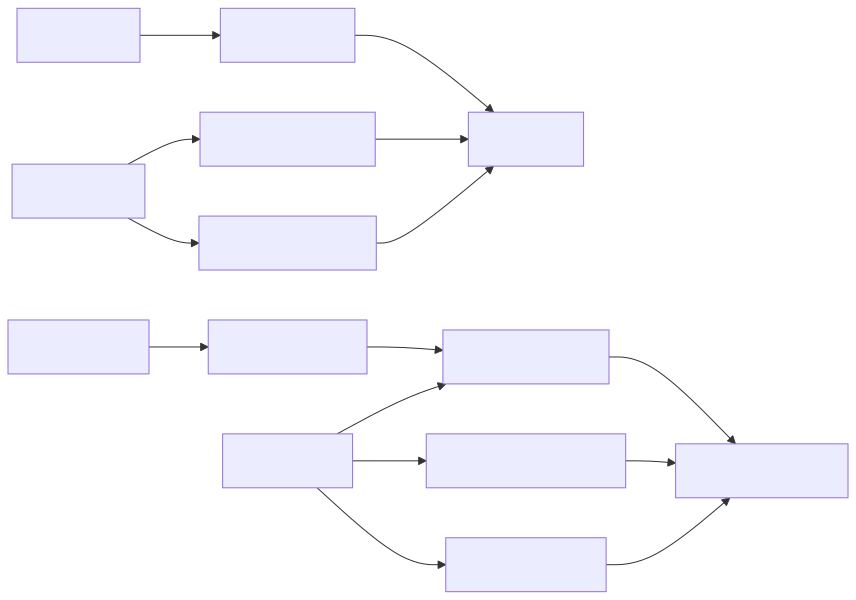

In [9]:
// Combine all edges and show as flat graph
const allEdges = [...linearEdges, ...dagEdges];
console.log(`Total edges from all workflows: ${allEdges.length}`);

// Display without grouping (flat graph)
await displayWorkflowEdges(allEdges, { grouped: false });

## Summary

**Workflow Templates enable:**

- ✅ Simple YAML format for defining tool sequences
- ✅ Two formats: `steps` (linear) or `edges` (DAG)
- ✅ Validation with unknown tool warnings
- ✅ Graph visualization for debugging
- ✅ Bootstrap GraphRAG with user-defined patterns

**Use cases:**

- Bootstrap empty graph with common patterns
- Define domain-specific tool chains
- Share workflow patterns across projects